# Carbon substrate

In [13]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *
from bacillusme.analysis import sensitivity as ss


import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


[autoreload of cobrame.core.reaction failed: Traceback (most recent call last):
  File "/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _ca

In [14]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')
ibsu_directory = join(flat_files.ecoli_files_dir, 'iBsu1103.json') 

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)
ibsu = cobra.io.load_json_model(ibsu_directory)

bsub.optimize()

<Solution 0.12 at 0x7fc5d7031278>

In [3]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)
glc_uptake = me.reactions.get_by_id('EX_glc__D_e').lower_bound


In [4]:
## biolog

biolog_df = pd.read_excel('biolog_plates.xlsx',sheet_name='C',index_col=0).dropna().drop_duplicates()
biolog_df

,met_id,exp_growth
met_name,,
L-Leucine,leu-L,0.0
L-Lysine,lys-L,0.0
L-Methionine,met-L,0.0
L-Phenylalanine,phe-L,0.0
"D,L-Carnitine",crn,0.0
...,...,...
Dihydroxy-Acetone,dha,1.0
Glycyl-L-Aspartic Acid,gly-asp-L,1.0
Glycyl-L-Glutamic Acid,gly-glu-L,1.0


In [45]:
get_reactions_of_met(me,'leu__L_e')

( LEUt2r_REV_BSU29600-MONOMER 0 999999.0 ) 	 4.27350427350427e-6*mu BSU29600-MONOMER + h_c + leu__L_c <=> h_e + leu__L_e
( LEUt2r_REV_BSU26690-MONOMER 0 999999.0 ) 	 4.27350427350427e-6*mu BSU26690-MONOMER + h_c + leu__L_c <=> h_e + leu__L_e
( EX_leu__L_e 0.0 999999.0 ) 	 leu__L_e --> 
( LEUt2r_FWD_BSU29600-MONOMER 0 999999.0 ) 	 4.27350427350427e-6*mu BSU29600-MONOMER + h_e + leu__L_e <=> h_c + leu__L_c
( LEUt2r_FWD_BSU26690-MONOMER 0 999999.0 ) 	 4.27350427350427e-6*mu BSU26690-MONOMER + h_e + leu__L_e <=> h_c + leu__L_c


[<MetabolicReaction LEUt2r_REV_BSU29600-MONOMER at 0x7fc5d30be550>,
 <MetabolicReaction LEUt2r_REV_BSU26690-MONOMER at 0x7fc5d30be358>,
 <MEReaction EX_leu__L_e at 0x7fc5d831ec88>,
 <MetabolicReaction LEUt2r_FWD_BSU29600-MONOMER at 0x7fc5d30be5c0>,
 <MetabolicReaction LEUt2r_FWD_BSU26690-MONOMER at 0x7fc5d30be4e0>]

In [5]:
met_list = []
met_dict = {}
uptake_rates = {}
for met_name,entry in biolog_df.iterrows():
    met_id = entry['met_id']
    old_id = met_id
    if type(met_id) != str:
        continue
        
    exp_growth = entry['exp_growth']
    met_id = re.sub(r'-([D,L])','__'+r'\1',met_id)
    met_id = met_id.replace('-','_') + '_e'
    if hasattr(bsub.metabolites,met_id):
        met_list.append(met_id)
        met_dict[met_id] = old_id
        
        met = me.metabolites.get_by_id(met_id)
        formula = me.metabolites.get_by_id(met_id).formula
        C_no = formula[formula.index('C')+1]
        C_no = float(C_no) if re.match('[0-9]',C_no) else 1.0
        uptake_rates[met_id] = glc_uptake * (6/C_no) # Ensure same C-mol uptake

In [222]:
flux_dict ={}
for met_id in tqdm(met_list):
    ss.feed_metabolite(bsub,met_id)
    bsub.optimize()
    flux_dict[met_id] = bsub.solution.x_dict
    bsub.reactions.get_by_id('EX_{}'.format(met_id)).lower_bound = 0
flux_response_m = pd.DataFrame.from_dict(flux_dict).fillna(0)



  0%|          | 0/86 [00:00<?, ?it/s]

  1%|          | 1/86 [00:00<00:09,  9.18it/s]

  3%|▎         | 3/86 [00:00<00:08,  9.83it/s]

  6%|▌         | 5/86 [00:00<00:07, 10.41it/s]

  8%|▊         | 7/86 [00:00<00:07, 10.55it/s]

 10%|█         | 9/86 [00:00<00:07, 10.57it/s]

 13%|█▎        | 11/86 [00:00<00:07, 10.71it/s]

 15%|█▌        | 13/86 [00:01<00:06, 11.41it/s]

 17%|█▋        | 15/86 [00:01<00:05, 11.97it/s]

 20%|█▉        | 17/86 [00:01<00:05, 12.37it/s]

 22%|██▏       | 19/86 [00:01<00:05, 12.66it/s]

 24%|██▍       | 21/86 [00:01<00:05, 12.86it/s]

 27%|██▋       | 23/86 [00:01<00:04, 12.92it/s]

 29%|██▉       | 25/86 [00:02<00:04, 13.17it/s]

 31%|███▏      | 27/86 [00:02<00:04, 13.38it/s]

 34%|███▎      | 29/86 [00:02<00:04, 13.29it/s]

 36%|███▌      | 31/86 [00:02<00:04, 13.40it/s]

 38%|███▊      | 33/86 [00:02<00:03, 13.45it/s]

 41%|████      | 35/86 [00:02<00:03, 13.40it/s]

 43%|████▎     | 37/86 [00:02<00:03, 13.49it/s]

 45%|████▌     | 39/86 [00:03<00

In [141]:
flux_response_m.to_csv('carbon_substrate/biolog_responses_m.csv')

In [6]:
me.reactions.get_by_id('EX_glc__D_e').lower_bound = 0

In [8]:
flux_response_me = ss.all_flux_responses(me,met_list,mu_fix=False,solution=me.solution,NP=12,precision=1e-4,
                       single_change_function='feed_metabolite',growth_key = 'mu',sequential=False,flux_dict=uptake_rates)


biomass_dilution response (12 threads):   0%|          | 0/86 [00:00<?, ?it/s]

In [142]:
flux_response_me.to_csv('carbon_substrate/biolog_responses_me.csv')

In [24]:
flux_response_m = pd.read_csv('carbon_substrate/biolog_responses_m.csv',index_col=0)
flux_response_me = pd.read_csv('carbon_substrate/biolog_responses_me.csv',index_col=0)

In [25]:
response_df = biolog_df.copy()
response_df.reset_index()
response_df = response_df.set_index('met_id')

In [26]:
response_dict ={}
for met_id in tqdm(met_list):
    response_dict[met_id] = {}
    response_dict[met_id]['m'] = 1. if flux_response_m.loc['BIOMASS_BS_10'][met_id]>1.0e-3 else 0.
    response_dict[met_id]['me'] = 1. if flux_response_me.loc['biomass_dilution'][met_id]>1.0e-3 else 0.
    response_dict[met_id]['exp'] = 1. if response_df.loc[met_dict[met_id]]['exp_growth'] else 0.
response_df = pd.DataFrame.from_dict(response_dict).T



  0%|          | 0/86 [00:00<?, ?it/s]

100%|██████████| 86/86 [00:00<00:00, 514.15it/s]


In [46]:
response_df[response_df.m != response_df.me]

,m,me,exp
galctr__D_e,1.0,0.0,1.0


In [48]:
response_df.to_csv('biolog_complete.csv')

In [39]:
TP = response_df[response_df.me == 1.0][response_df.me == response_df.exp].shape[0]
FP = response_df[response_df.me == 1.0][response_df.me != response_df.exp].shape[0]
TN = response_df[response_df.me == 0.0][response_df.me == response_df.exp].shape[0]
FN = response_df[response_df.me == 0.0][response_df.me != response_df.exp].shape[0]
MCC = (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
BER = 1 - 0.5*(TPR+TNR)
print(TP,FP,TN,FN,MCC,BER)

69 4 6 7 0.45451414375297394 0.2460526315789473


/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:1 UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:2 UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:3 UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:4 UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [40]:
TP = response_df[response_df.m == 1.0][response_df.m == response_df.exp].shape[0]
FP = response_df[response_df.m == 1.0][response_df.m != response_df.exp].shape[0]
TN = response_df[response_df.m == 0.0][response_df.m == response_df.exp].shape[0]
FN = response_df[response_df.m == 0.0][response_df.m != response_df.exp].shape[0]
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
BER = 1 - 0.5*(TPR+TNR)
print(TP,FP,TN,FN,MCC,BER)

70 4 6 6 0.45451414375297394 0.23947368421052628


/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:1 UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:2 UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:3 UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:4 UserWarning: Boolean Series key will be reindexed to match DataFrame index.


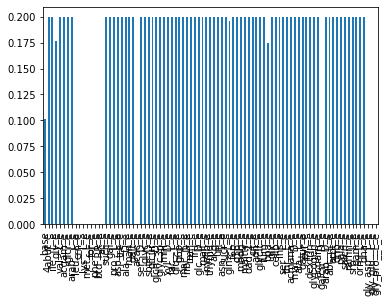

In [186]:
flux_response_me.loc['biomass_dilution'].plot.bar()

In [175]:
response_df

,m,me,exp
leu__L_e,0.0,0.0,0.0
lys__L_e,0.0,0.0,0.0
met__L_e,0.0,0.0,0.0
phe__L_e,0.0,0.0,0.0
crn_e,0.0,0.0,0.0
...,...,...,...
orn__L_e,1.0,1.0,1.0
dha_e,1.0,1.0,1.0
gly_asp__L_e,0.0,0.0,1.0
gly_glu__L_e,0.0,0.0,1.0


In [9]:
me.metabolites.get_by_id('galctr__D_e').name

'D Galactarate C6H8O8'

In [15]:
for m in me.metabolites:
    if isinstance(m,cobrame.GenericComponent):
        print(m.id)

generic_16Sm4Cm1402
generic_LYSINEaaRS
generic_Dus
generic_RF
generic_Tuf
generic_RNase
generic_5s_rRNAs
generic_16s_rRNAs
generic_23s_rRNAs
generic_2fe2s_transfer_complex
generic_4fe4s_transfer_complex


In [18]:
get_reactions_of_met(me,'generic_RNase')

( formation_polycistronic_wout_rRNA_excision_machinery 0.0 1000.0 ) 	 BSU23840-MONOMER + BSU41050-MONOMER + generic_RNase --> polycistronic_wout_rRNA_excision_machinery
( formation_monocistronic_excision_machinery 0.0 1000.0 ) 	 BSU23840-MONOMER + BSU41050-MONOMER + generic_RNase --> monocistronic_excision_machinery
( BSU28370-MONOMER_to_generic_RNase 0.0 1000.0 ) 	 BSU28370-MONOMER --> generic_RNase


[<ComplexFormation formation_polycistronic_wout_rRNA_excision_machinery at 0x7fc5d2dd96a0>,
 <ComplexFormation formation_monocistronic_excision_machinery at 0x7fc5d2dd9630>,
 <GenericFormationReaction BSU28370-MONOMER_to_generic_RNase at 0x7fc5d2dca550>]

In [42]:
me.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
me.reactions.get_by_id('EX_glc__D_e').upper_bound = 0

me.reactions.get_by_id('EX_galctr__D_e').lower_bound = 0
me.reactions.get_by_id('EX_galctr__D_e').upper_bound = 0


In [43]:
solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-6)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 208.165550 seconds
Finished substituting S,lb,ub in 8.969414 seconds
Finished makeME_LP in 1.095391 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 8.831810 seconds
Finished makeME_LP in 1.092378 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 8.952778 seconds
Finished makeME_LP in 1.106566 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.0625 0.0625 1
Finished substituting S,lb,ub in 8.843260 seconds
Finished makeME_LP in 1.100505 seconds
Getting MINOS parameters from ME_NLP...
4 0.0 0.0 0.03125 0.03125 1
Finished substituting S,lb,ub in 9.096864 seconds
Finished makeME_LP in 1.093191 seconds
Getting MINOS parameters from ME_NLP...
5 0.0 0.0 0.015625 0.015625 1
Finished substituting S,lb,ub in 8.974474 seconds
Finished makeME_LP in 1.091662 seconds
Getting MINOS parameters from ME_NLP.